In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import nest
import numpy as np
import os
import scipy as sp
import scipy.stats
import unittest

Test postsynaptic trace
=======================

Pre- and postsynaptic traces are used to calculate STDP weight updates, but are computed differently: postsynaptic traces are stored and maintained in the NEST C++ `Archiving_Node` class. Following [nest-simulator#1034](https://github.com/nest/nest-simulator/issues/1034), this notebook (and corresponding test script in `testsuite/regressiontests/issue-1034.py`) was created to specifically test the postsynaptic trace value, by comparing the NEST-obtained samples to a Python-generated reference timeseries.

Construct a network of the form:
- pre_spike_gen connects via static_synapse to pre_parrot
- pre_parrot connects via stdp_synapse to post_parrot
- post_spike_gen connects via static_synapse to post_parrot

The spike times of the spike generators are defined in
`pre_spike_times` and `post_spike_times`. From the perspective of the
STDP synapse, spikes arrive with the following delays (with respect to
the values in these lists):

- for the presynaptic neuron: one synaptic delay in the static synapse
- for the postsynaptic neuron: one synaptic delay in the static synapse
- for the synapse itself: one dendritic delay between the post_parrot
  node and the synapse itself (see the C++ variable `dendritic_delay`).

NEST simulation
---------------

Construct and run the NEST network.

In [3]:
def run_post_trace_test_nest_(pre_spike_times, post_spike_times,
                              resolution, delay, sim_time, tau_minus,
                              show_all_nest_trace_samples=False,
                              debug=False):

    if debug:
        print("Pre spike times: ["
              + ", ".join([str(t) for t in pre_spike_times]) + "]")
        print("Post spike times: ["
              + ", ".join([str(t) for t in post_spike_times]) + "]")

    nest.set_verbosity("M_WARNING")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    wr = nest.Create('weight_recorder')
    nest.CopyModel("stdp_synapse", "stdp_synapse_rec",
                   {"weight_recorder": wr[0], "weight": 1.})

    # create spike_generators with these times
    pre_sg_ps = nest.Create("spike_generator",
                            params={"spike_times": pre_spike_times,
                                    'precise_times': True})
    post_sg_ps = nest.Create("spike_generator",
                             params={"spike_times": post_spike_times,
                                     'precise_times': True})

    # create parrot neurons and connect spike_generators
    pre_parrot_ps = nest.Create("parrot_neuron_ps")
    post_parrot_ps = nest.Create("parrot_neuron_ps",
                                 params={"tau_minus": tau_minus})

    nest.Connect(pre_sg_ps, pre_parrot_ps,
                 syn_spec={"delay": delay})
    nest.Connect(post_sg_ps, post_parrot_ps,
                 syn_spec={"delay": delay})

    # create spike detector --- debugging only
    spikes = nest.Create("spike_detector",
                         params={'precise_times': True})
    nest.Connect(
        pre_parrot_ps + post_parrot_ps,
        spikes
    )

    # connect both parrot neurons with a stdp synapse onto port 1
    # thereby spikes transmitted through the stdp connection are
    # not repeated postsynaptically.
    nest.Connect(
        pre_parrot_ps, post_parrot_ps,
        syn_spec={'model': 'stdp_synapse_rec',
                  'receptor_type': 1,
                  'delay': delay})

    # get STDP synapse
    syn_ps = nest.GetConnections(source=pre_parrot_ps,
                                 synapse_model="stdp_synapse_rec")

    if debug:
        print("[py] Total simulation time: " + str(sim_time) + " ms")
    n_steps = int(np.ceil(sim_time / delay))
    trace_nest = []
    trace_nest_t = []
    t = nest.GetStatus([0], "time")[0]
    trace_nest_t.append(t)
    post_tr = nest.GetStatus(post_parrot_ps)[0]['post_trace']
    trace_nest.append(post_tr)
    for step in range(n_steps):
        if debug:
            print("\n[py] simulating for " + str(delay) + " ms")
        nest.Simulate(delay)
        t = nest.GetStatus([0], "time")[0]
        nearby_pre_spike = np.any(
            np.abs(t - np.array(pre_spike_times) - delay) < resolution/2.)
        if show_all_nest_trace_samples or nearby_pre_spike:
            trace_nest_t.append(t)
            post_tr = nest.GetStatus(post_parrot_ps)[0]['post_trace']
            trace_nest.append(post_tr)
            if debug:
                print("[py] Received NEST trace: " +
                      str(post_tr) + " at time t = " + str(t))

    return trace_nest_t, trace_nest

Python simulation
-----------------

Generate the Python reference timeseries.

In [4]:
def run_post_trace_test_python_reference_(pre_spike_times,
                                          post_spike_times, resolution,
                                          delay, dendritic_delay, sim_time,
                                          tau_minus, debug=False):
    """
    compute Python known-good reference of postsynaptic trace
    """

    n_timepoints = 1000 * int(np.ceil(sim_time))
    trace_python_ref = np.zeros(n_timepoints)

    n_spikes = len(post_spike_times)
    for sp_idx in range(n_spikes):
        t_sp = post_spike_times[sp_idx] + delay + dendritic_delay
        for i in range(n_timepoints):
            t = (i / float(n_timepoints - 1)) * sim_time
            if t > t_sp:
                trace_python_ref[i] += np.exp(-(t - t_sp) / tau_minus)

    n_spikes = len(pre_spike_times)
    for sp_idx in range(n_spikes):
        t_sp = pre_spike_times[sp_idx] + delay
        i = int(np.round(t_sp / sim_time
                         * float(len(trace_python_ref) - 1)))
        if debug:
            print("* At t_sp = " + str(t_sp)
              + ", post_trace should be " + str(trace_python_ref[i]))

    return trace_python_ref

Run the test
------------

First, define some pre/post spike patterns.

In [5]:
# spike test pattern 1: minimal reproducing example of the original bug
pre_spike_times1 = np.array([2., 3., 10.])
post_spike_times1 = np.array([1., 2., 3.])

# spike test pattern 2: generate some random integer spike times
t_sp_min = 1.
t_sp_max = 50
n_spikes = 10
pre_spike_times2 = np.sort(
    np.unique(
        np.ceil(
            sp.stats.uniform.rvs(
                t_sp_min, t_sp_max - t_sp_min, n_spikes))))
n_spikes = 50
post_spike_times2 = np.sort(
    np.unique(
        np.ceil(
            sp.stats.uniform.rvs(
                t_sp_min, t_sp_max - t_sp_min, n_spikes))))
tau_minus = 2.  # [ms]

# for each parameter set, run the test
# spike test pattern 3 is a pre/post-reversed version of test pattern 2
pre_spike_times = [pre_spike_times1,
                   pre_spike_times2,
                   post_spike_times2]
post_spike_times = [post_spike_times1,
                    post_spike_times2,
                    pre_spike_times2]

Define a function that will validate equality between the Python-generated and the NEST-generated timeseries.

In [6]:
trace_match_atol = 1E-3
trace_match_rtol = 1E-3

def nest_trace_matches_ref_trace(trace_nest_t, trace_nest,
                                 trace_python_ref, pre_spike_times,
                                 post_spike_times, resolution, delay,
                                 dendritic_delay, trace_match_atol,
                                 trace_match_rtol, sim_time,
                                 debug=False):
    """
    Trace values are returned from NEST at regular intervals, but only
    updated at presynaptic spike times.

    To match the NEST samples with the continuous reference trace, step
    backwards in time from the sampled value, to find the last time at
    which the trace value was updated, namely the time of occurrence of
    the last presynaptic spike.
    """

    n_timepoints = len(trace_nest_t)
    for i in range(n_timepoints)[1:]:
        t = trace_nest_t[i]
        if debug:
            print("* Finding ref for NEST timepoint t = " + str(t)
                  + ", NEST trace = " + str(trace_nest[i]))

        traces_match = False
        for i_search, t_search in enumerate(
                reversed(np.array(pre_spike_times) + delay)):
            if t_search <= t:
                _trace_at_t_search = trace_python_ref[int(np.round(
                    t_search / sim_time
                    * float(len(trace_python_ref) - 1)))]
                traces_match = np.allclose(
                    _trace_at_t_search,
                    trace_nest[i],
                    atol=trace_match_atol,
                    rtol=trace_match_rtol)
                post_spike_occurred_at_t_search = np.any(
                    (t_search - (np.array(post_spike_times)
                                 + delay
                                 + dendritic_delay))**2
                    < resolution/2.)

                if debug:
                    print("\t* Testing " + str(t_search) + "...")
                    print("\t   traces_match = " + str(traces_match))
                    print("\t   post_spike_occurred_at_t_search = "
                          + str(post_spike_occurred_at_t_search))

                if (not traces_match) and post_spike_occurred_at_t_search:
                    traces_match = np.allclose(
                        _trace_at_t_search + 1,
                        trace_nest[i],
                        atol=trace_match_atol,
                        rtol=trace_match_rtol)
                    if debug:
                        print("\t   traces_match = " + str(traces_match)
                              + " (nest trace = " + str(trace_nest[i])
                              + ", ref trace = "
                              + str(_trace_at_t_search + 1)
                              + ")")
                    if traces_match:
                        _trace_at_t_search += 1.

                if (not traces_match) and post_spike_occurred_at_t_search:
                    traces_match = np.allclose(
                        _trace_at_t_search - 1,
                        trace_nest[i],
                        atol=trace_match_atol,
                        rtol=trace_match_rtol)
                    if debug:
                        print("\t   traces_match = " + str(traces_match)
                              + " (nest trace = " + str(trace_nest[i])
                              + ", ref trace = "
                              + str(_trace_at_t_search - 1)
                              + ")")
                    if traces_match:
                        _trace_at_t_search -= 1.

                break

        if (not traces_match) and i_search == len(pre_spike_times) - 1:
            if debug:
                print("\tthe time before the first pre spike")
            # the time before the first pre spike
            traces_match = trace_nest[i] == 0.

        if not traces_match:
            return False

    return True


Plotting function:

In [7]:
def plot_run(trace_nest_t, trace_nest, trace_python_ref,
             pre_spike_times, post_spike_times, resolution, delay,
             dendritic_delay, trace_match_atol, trace_match_rtol,
             sim_time, title_snip="", debug=False):

    fig, ax = plt.subplots(nrows=3, dpi=120)
    ax1, ax2, ax3 = ax

    #
    #   pre spikes
    #

    ax1.set_ylim([0., 1.])
    ax1.set_ylabel("Pre spikes")
    n_spikes = len(pre_spike_times)
    for i in range(n_spikes):
        ax1.plot(2 * [pre_spike_times[i] + delay],
                 ax1.get_ylim(),
                 linewidth=2, color="blue", alpha=.4)

    #
    #   post spikes
    #

    ax2.set_ylim([0., 1.])
    ax2.set_ylabel("Post spikes")
    n_spikes = len(post_spike_times)
    for i in range(n_spikes):
        ax2.plot(2 * [post_spike_times[i] + delay + dendritic_delay],
                 [0, 1],
                 linewidth=2, color="red", alpha=.4)

    #
    #   traces
    #

    ax3.set_ylabel("Synaptic trace")
    ax3.set_ylim([0., np.amax(trace_python_ref)])
    ax3.plot(np.linspace(0., sim_time, len(trace_python_ref)),
             trace_python_ref,
             label="Expected", color="cyan", alpha=.6)
    ax3.scatter(trace_nest_t, trace_nest,
                marker=".", alpha=.5, color="orange", label="NEST")
    ax3.legend()

    #
    #   Trace values are returned from NEST at regular intervals, but only
    #   updated at presynaptic spike times.
    #
    #   Step backwards in time from the sampled value, to find the last
    #   time at which the trace value was updated, namely the time of
    #   occurrence of the last presynaptic spike.
    #

    pre_spike_times = np.array(pre_spike_times)
    n_timepoints = len(trace_nest_t)
    for i in range(n_timepoints):
        t = trace_nest_t[i]
        if debug:
            print("* Finding ref for NEST timepoint t = "
                  + str(t) + ", trace = " + str(trace_nest[i]))
        for t_search in reversed(pre_spike_times + delay):
            if t_search <= t:
                if debug:
                    print("\t* Testing " + str(t_search) + "...")
                _idx = int(np.round(t_search / sim_time
                           * float(len(trace_python_ref) - 1)))
                _trace_at_t_search = trace_python_ref[_idx]
                traces_match = np.allclose(_trace_at_t_search,
                                           trace_nest[i],
                                           atol=trace_match_atol,
                                           rtol=trace_match_rtol)
                if debug:
                    print("\t   traces_match = " + str(traces_match))
                if not traces_match:
                    post_spike_occurred_at_t_search = np.any(
                        (t_search - (np.array(post_spike_times)
                         + delay + dendritic_delay))**2 < resolution/2.)
                    if debug:
                        print("\t   post_spike_occurred_at_t_search = "
                              + str(post_spike_occurred_at_t_search))
                    if post_spike_occurred_at_t_search:
                        traces_match = np.allclose(
                            _trace_at_t_search + 1,
                            trace_nest[i],
                            atol=trace_match_atol,
                            rtol=trace_match_rtol)
                        if debug:
                            print("\t   traces_match = " + str(traces_match)
                                  + " (nest trace = " + str(trace_nest[i])
                                  + ", ref trace = "
                                  + str(_trace_at_t_search+1) + ")")
                        
                        if traces_match:
                            _trace_at_t_search += 1.

                        if not traces_match:
                            traces_match = np.allclose(
                                _trace_at_t_search - 1,
                                trace_nest[i],
                                atol=trace_match_atol,
                                rtol=trace_match_rtol)
                            
                            if debug:
                                print("\t   traces_match = "
                                      + str(traces_match)
                                      + " (nest trace = "
                                      + str(trace_nest[i])
                                      + ", ref trace = "
                                      + str(_trace_at_t_search-1) + ")")
                            
                            if traces_match:
                                _trace_at_t_search -= 1.

                ax3.scatter(t_search, _trace_at_t_search, 100, marker=".",
                            color="#A7FF00FF", facecolor="none")
                ax3.plot([trace_nest_t[i], t_search],
                         [trace_nest[i], _trace_at_t_search],
                         linewidth=.5, color="#0000007F")
                break

    for _ax in ax:
        _ax.xaxis.set_major_locator(
            plticker.MultipleLocator(base=10*delay))
        _ax.xaxis.set_minor_locator(
            plticker.MultipleLocator(base=delay))
        _ax.grid(which="major", axis="both")
        _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
        _ax.set_xlim(0., sim_time)

    ax3.set_xlabel("Time [ms]")
    fig.suptitle("""Postsynaptic trace testbench. Spike times are\n"""
                 """shown from the perspective of the STDP synapse """ + title_snip)

Now, run the test and make the plots while we go.

The plots should be interpreted as follows. Pre- and postsynaptic spikes are shown in the top two subplots, at the time at which they arrive at the synapse (i.e. from the perspective of the synapse, taking dendritic and axonal delays into account).

The bottom subplot shows the reference/known-good timeseries generated (numerically) in Python (**cyan colour**). The values returned from NEST are shown using **orange circles**. They are plotted as points rather than as a continuous line, because we can only retrieve the value at the resolution of the minimum synaptic delay (i.e. fetch trace value; simulate for a timestep `delay`; repeat). Moreover, the postsynaptic trace value is only updated in NEST during the processing of a presynaptic spike, so unless a presynaptic spike was processed in the last delay interval, the value will remain unchanged. To allow comparison between the Python- and NEST-generated values, we thus search for the previous time at which NEST would have updated the trace value, which is the time of arrival of the last presynaptic spike. This value is marked by an **open green circle**. If all is well, all green circles should always overlap an orange circle, and all **black lines** (which simply connect subsequent postsynaptic trace values returned by NEST) should be perfectly horizontal.

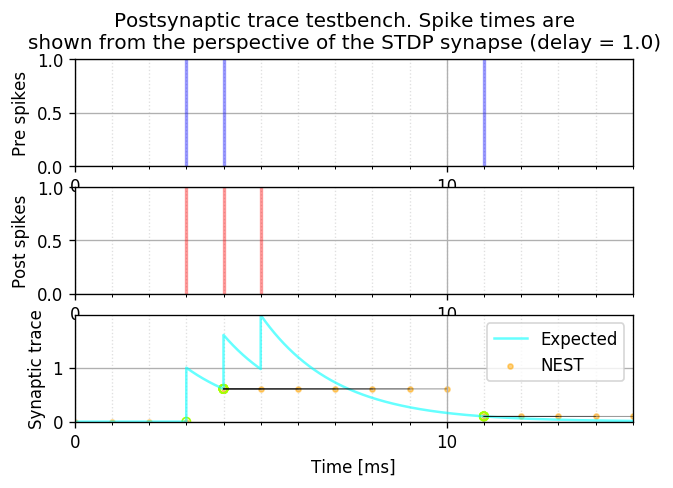

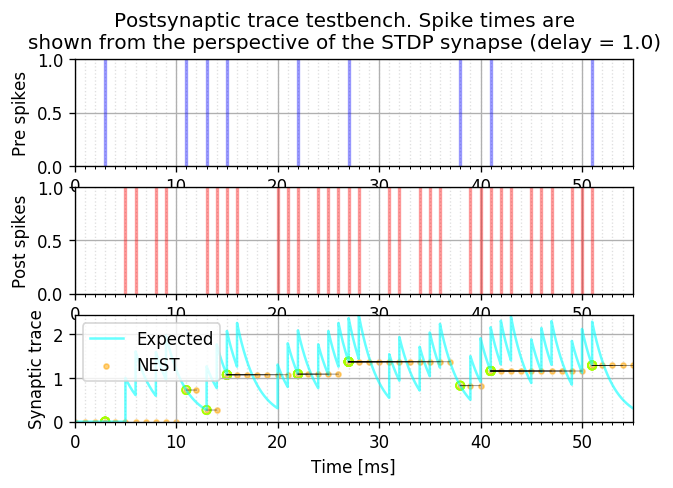

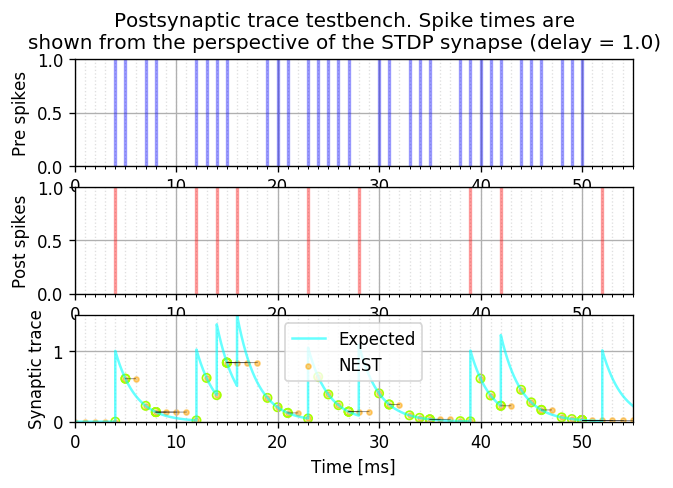

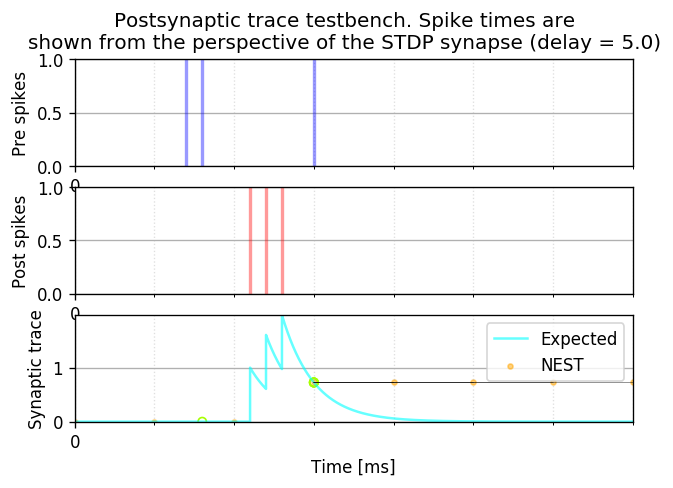

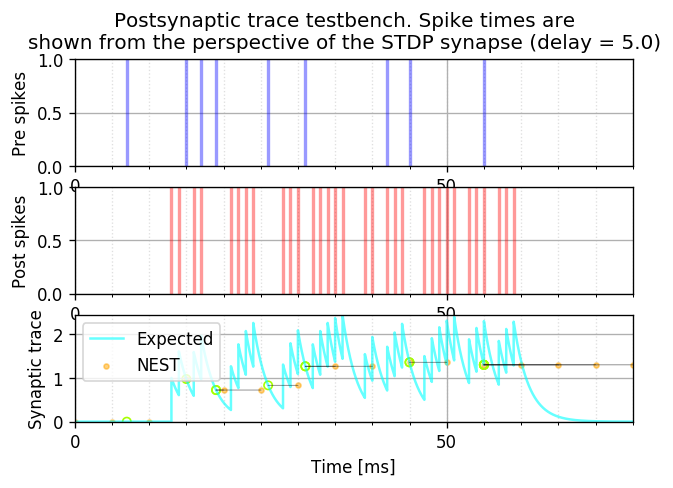

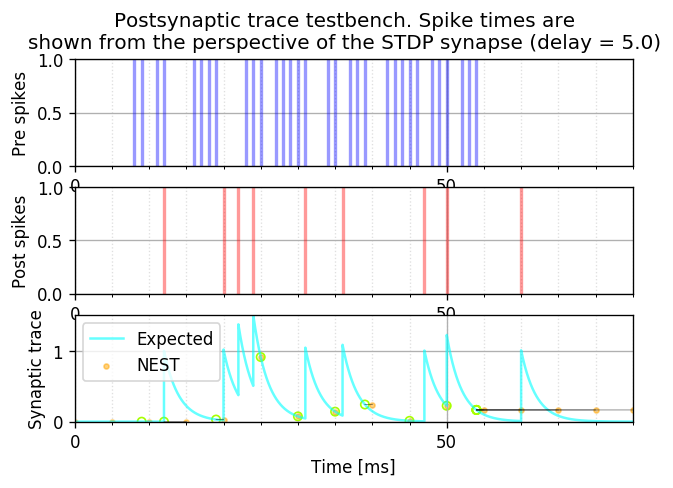

In [8]:
resolution = .1     # [ms]
delays = np.array([1., 5.])  # [ms]

# settings for plotting debug information
show_all_nest_trace_samples = True

for delay in delays:
    dendritic_delay = delay
    for spike_times_idx in range(len(pre_spike_times)):
        max_t_sp = max(np.amax(pre_spike_times[spike_times_idx]),
                       np.amax(post_spike_times[spike_times_idx]))
        sim_time = max_t_sp + 5 * delay
        trace_nest_t, trace_nest = run_post_trace_test_nest_(
            pre_spike_times[spike_times_idx],
            post_spike_times[spike_times_idx],
            resolution, delay, sim_time, tau_minus,
            show_all_nest_trace_samples)
        trace_python_ref = run_post_trace_test_python_reference_(
            pre_spike_times[spike_times_idx],
            post_spike_times[spike_times_idx],
            resolution, delay, dendritic_delay, sim_time, tau_minus)

        title_snip = "(delay = " \
                + str(delay) \
                + ")"
        plot_run(
            trace_nest_t, trace_nest, trace_python_ref,
            pre_spike_times[spike_times_idx],
            post_spike_times[spike_times_idx], resolution, delay,
            dendritic_delay, trace_match_atol, trace_match_rtol,
            sim_time, title_snip)
        assert nest_trace_matches_ref_trace(
            trace_nest_t,
            trace_nest,
            trace_python_ref,
            pre_spike_times[spike_times_idx],
            post_spike_times[spike_times_idx],
            resolution, delay, dendritic_delay,
            trace_match_atol,
            trace_match_rtol,
            sim_time,
            debug=False)
